# Compare MCMC with BBVI 

In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import sys
import os

# Set path such that interpreter finds tigerpy
sys.path.append(os.path.join(os.getcwd(), ".."))

import liesel.goose as gs
import liesel.model as lsl
from liesel.distributions.mvn_degen import MultivariateNormalDegenerate as LieselMultivariateNormalDegenerate
from liesel.goose.types import Array

import tigerpy.model as tiger
import tigerpy.bbvi as bbvi
from tigerpy.distributions import MultivariateNormalDegenerate as TigerpyMultivariateNormalDegenerate

# Use distributions from tensorflow probability
import tensorflow_probability.substrates.jax.distributions as tfjd
import tensorflow_probability.substrates.jax.bijectors as tfjb

In [2]:
import simulation.sim_fun.sim_data as sim_data

In [3]:
data = sim_data.normal_complex_const(1000, key_int=0)

In [4]:
data["data"]

,loc,scale,x,y
0,4.243893,1.5,-6.810272,4.511619
1,2.979623,1.5,-0.007763,0.129234
2,4.154692,1.5,-3.708401,3.962524
3,1.882459,1.5,-8.839361,-1.197223
4,1.833416,1.5,-4.675233,-0.102184
...,...,...,...,...
995,4.401037,1.5,0.618856,2.861006
996,1.258252,1.5,-9.489546,0.675084
997,3.404877,1.5,-8.221931,2.488900
998,1.286359,1.5,-5.372121,1.006212


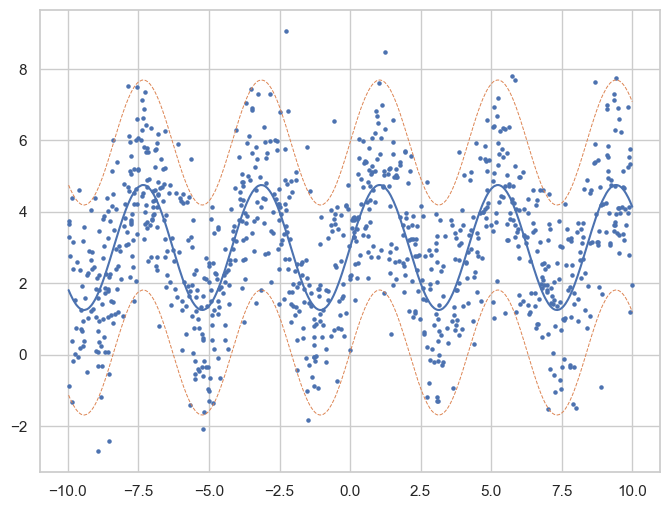

In [5]:
sim_data.plot_sim_data(data["data"], dist="normal")

## Fit from BBVI

In [6]:
# Preprocess data 
x = data["data"]["x"]
y = data["data"]["y"]

In [7]:
# Define a model with intercept 
# Set up design matrix 
X = tiger.Obs(name="X_loc", intercept=True)
X.smooth(data=x)
# If we combine fixed covariates and smooth covariates we need to center the the smooth effects first 
X.center()

# Fixed coefficents 
# Set up beta_fixed hyperparameters 
beta_fixed_loc = tiger.Hyper(0.0, name="beta_fixed_loc")
beta_fixed_scale = tiger.Hyper(100.0, name="beta_fixed_scale")

# Set up parameters
beta_fixed_dist = tiger.Dist(tfjd.Normal, loc=beta_fixed_loc, scale=beta_fixed_scale)
beta_fixed = tiger.Param(value=y.to_numpy().mean(), distribution=beta_fixed_dist, name="beta_fixed")

# Smooth coefficients
# Set up hyperparameters for the beta_smooth_scale  
tau_a = tiger.Hyper(1.0, name="tau_a")
tau_b = tiger.Hyper(0.00005, name="tau_b")
tau_dist = tiger.Dist(tfjd.InverseGamma, concentration=tau_a, scale=tau_b)
tau = tiger.Param(value=jnp.array([1.0]), distribution=tau_dist, param_space="positive", name="tau")

# Smooth coefficients
# Set up smooth coefficients with mvn degenerate 
# Set up hyperparameters
beta_smooth_loc = tiger.Hyper(np.zeros(X.smooth_dim_cent[0]), name="beta_smooth_loc")

# Define the penalty matrix 
pen = X.smooth_pen_mat_cent[0]

# Set up parameters
beta_smooth_dist = tiger.Dist(TigerpyMultivariateNormalDegenerate, loc=beta_smooth_loc, scale=tau, pen=pen)
beta_smooth = tiger.Param(value=np.zeros(X.smooth_dim_cent[0]), distribution=beta_smooth_dist, name="beta_smooth")
# ----

# Set up the linear predictor
lpred = tiger.Lpred(obs=X, beta_fixed=beta_fixed, beta_smooth=beta_smooth)

# Set up hyperparameters for the scale  
sigma_a = tiger.Hyper(0.01, name="sigma_a")
sigma_b = tiger.Hyper(0.01, name="sigma_b")

sigma_dist = tiger.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = tiger.Param(value=10.0, distribution=sigma_dist, param_space="positive", name="sigma")

# Set up response distribution
response_dist = tiger.Dist(tfjd.Normal, loc=lpred, scale=sigma)
m = tiger.Model(response=y.to_numpy(), distribution=response_dist)

In [8]:
graph = tiger.ModelGraph(model=m)
graph.build_graph()

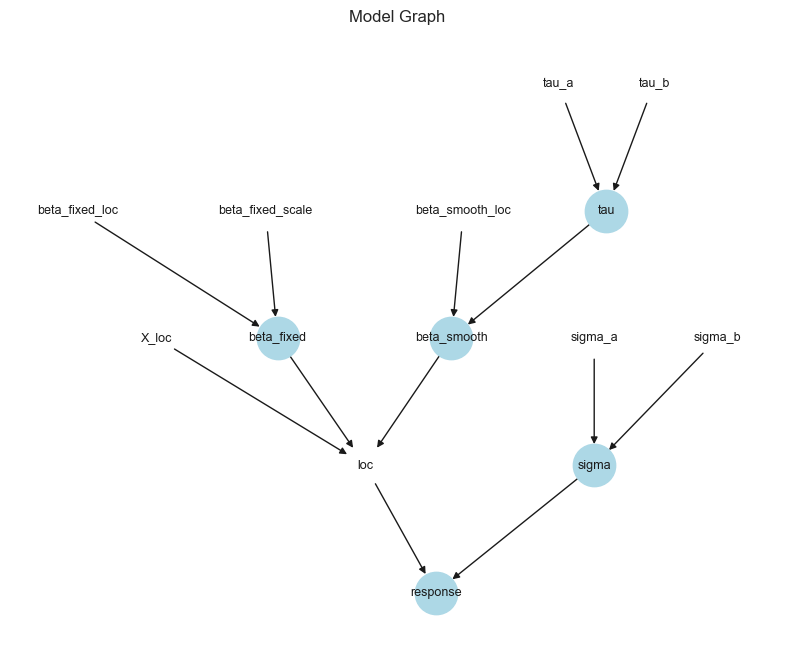

In [9]:
graph.visualize_graph()

In [10]:
q = bbvi.Bbvi(graph=graph)

In [11]:
q.run_bbvi(step_size=0.01,
           threshold=1e-2,
           key_int=1,
           batch_size=256,
           num_var_samples=64,
           chunk_size=50,
           epochs=500)

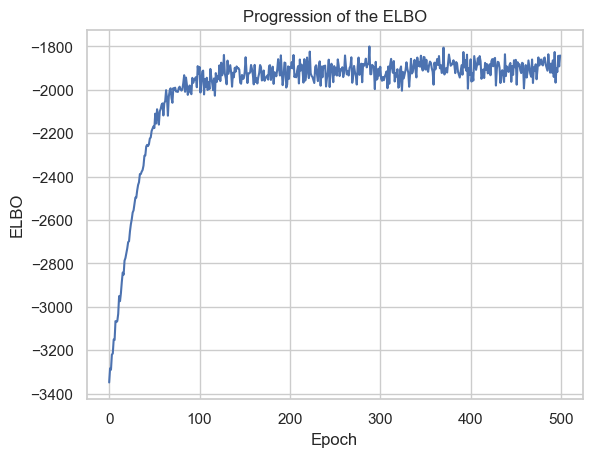

In [12]:
q.plot_elbo()

In [13]:
b_fixed = q.trans_var_params["beta_fixed"]["loc"]
b_smooth = q.trans_var_params["beta_smooth"]["loc"]
b = jnp.concatenate((b_fixed, b_smooth))
y_opt = X.design_matrix @ b

In [14]:
pred_data_tiger = pd.DataFrame({"x": x, "y":y_opt})
sort_pred_data_tiger = pred_data_tiger.sort_values("x")

In [15]:
sort_df = data["data"].sort_values("x")

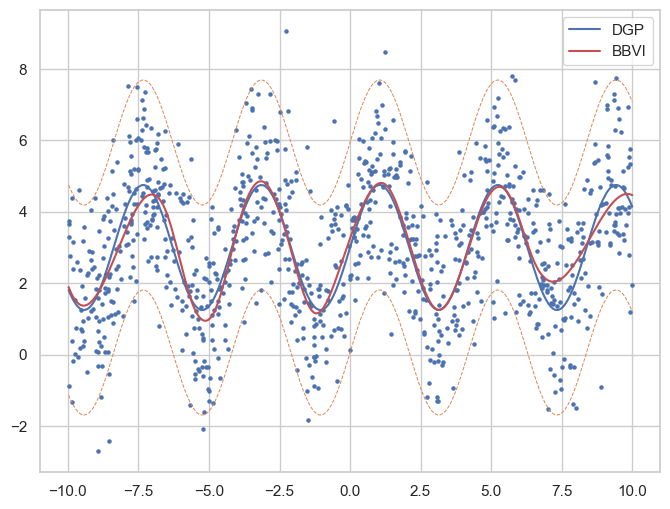

In [16]:
# plot the data
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

plt.scatter(x=sort_df["x"], y=sort_df["y"], s=5)
plt.plot(sort_df["x"], sort_df["loc"], label="DGP")
plt.plot(sort_df["x"], sort_df["loc"] + 1.96*sort_df["scale"], linewidth=0.7, color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_df["x"], sort_df["loc"] - 1.96*sort_df["scale"], linewidth=0.7, color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y"], color = "r", label = "BBVI")
plt.legend()
plt.show()

sns.reset_orig()

## Fit from liesel

In [17]:
# Define Groups for the smooth parameter priors
class VarianceIG(lsl.Group):
    def __init__(
        self, name: str, a: float, b: float, start_value: float = 1.0
    ) -> None:
        a_var = lsl.Var(a, name=f"{name}_a")
        b_var = lsl.Var(b, name=f"{name}_b")

        prior = lsl.Dist(tfjd.InverseGamma, concentration=a_var, scale=b_var)
        tau2 = lsl.Param(start_value, distribution=prior, name=name)
        super().__init__(name=name, a=a_var, b=b_var, tau2=tau2)

class SplineCoef(lsl.Group):
    def __init__(self, name: str, penalty: Array, tau2: lsl.Param) -> None:
        penalty_var = lsl.Var(penalty, name=f"{name}_penalty")

        # we save the rank of the penalty matrix here to use it later in our
        # gibbs kernel
        rank = lsl.Data(np.linalg.matrix_rank(penalty), _name=f"{name}_rank")

        prior = lsl.Dist(
            LieselMultivariateNormalDegenerate.from_penalty,
            loc=0.0,
            var=tau2,
            pen=penalty_var,
        )
        start_value = np.zeros(np.shape(penalty)[-1], np.float32)

        coef = lsl.Param(start_value, distribution=prior, name=name)
        
        super().__init__(name, coef=coef, penalty=penalty_var, tau2=tau2, rank=rank)

class PSpline(lsl.Group):
    def __init__(
        self, name, basis_matrix: Array, penalty: Array, tau2_group: lsl.Group
    ) -> None:
        coef_group = SplineCoef(
            name=f"{name}_coef", penalty=penalty, tau2=tau2_group["tau2"]
        )

        basis_matrix = lsl.Obs(basis_matrix, name="basis_matrix")
        smooth = lsl.Var(
            lsl.Calc(jnp.dot, basis_matrix, coef_group["coef"]), name=name
        )

        group_vars = coef_group.nodes_and_vars | tau2_group.nodes_and_vars

        super().__init__(
            name=name,
            basis_matrix=basis_matrix,
            smooth=smooth,
            **group_vars
        )

In [18]:
# Set up model in liesel
# Fixed parameter prior
beta_loc = lsl.Var(0.0, name="beta_loc")
beta_scale = lsl.Var(100.0, name="beta_scale")

# Set up the fixed parameters
beta_dist = lsl.Dist(tfjd.Normal, loc=beta_loc, scale=beta_scale)
beta = lsl.Param(value=np.array([0.0]), distribution=beta_dist, name="beta")

# Set up the smooth parameters
tau2_group = VarianceIG(name="tau2", a=1.0, b=0.0005)

penalty = X.smooth_pen_mat_cent[0]
smooth_group_1 = PSpline(name="smooth_1", basis_matrix=X.design_mat_cent[1], penalty=penalty, tau2_group=tau2_group)

# Set up the scale 
sigma_a = lsl.Var(0.01, name="sigma_a")
sigma_b = lsl.Var(0.01, name="sigma_b")

sigma_dist = lsl.Dist(tfjd.InverseGamma, concentration=sigma_a, scale=sigma_b)
sigma = lsl.Param(value=10.0, distribution=sigma_dist, name="sigma")

Z = lsl.Obs(X.fixed_data, name="Z")

lpred_loc_fn = lambda z, beta, smooth_1: jnp.dot(z, beta) + smooth_1
lpred_loc_calc = lsl.Calc(lpred_loc_fn, z=Z, beta=beta, smooth_1=smooth_group_1["smooth"])

lpred_loc = lsl.Var(lpred_loc_calc, name="lpred_loc")

response_dist = lsl.Dist(tfjd.Normal, loc=lpred_loc, scale=sigma)
response = lsl.Var(y.to_numpy(), distribution=response_dist, name="response")

In [19]:
gb = lsl.GraphBuilder().add(response)
gb.add_groups(smooth_group_1)
gb.transform(sigma, tfjb.Exp)

liesel.model.model - INFO - Converted dtype of Data(name="smooth_1_coef_penalty_value").value
liesel.model.model - INFO - Converted dtype of Data(name="beta_value").value
liesel.model.model - INFO - Converted dtype of Data(name="Z_value").value


Var(name="sigma_transformed")

In [20]:
gb

GraphBuilder(1 nodes, 9 vars)

In [21]:
model = gb.build_model()
model

Model(46 nodes, 17 vars)

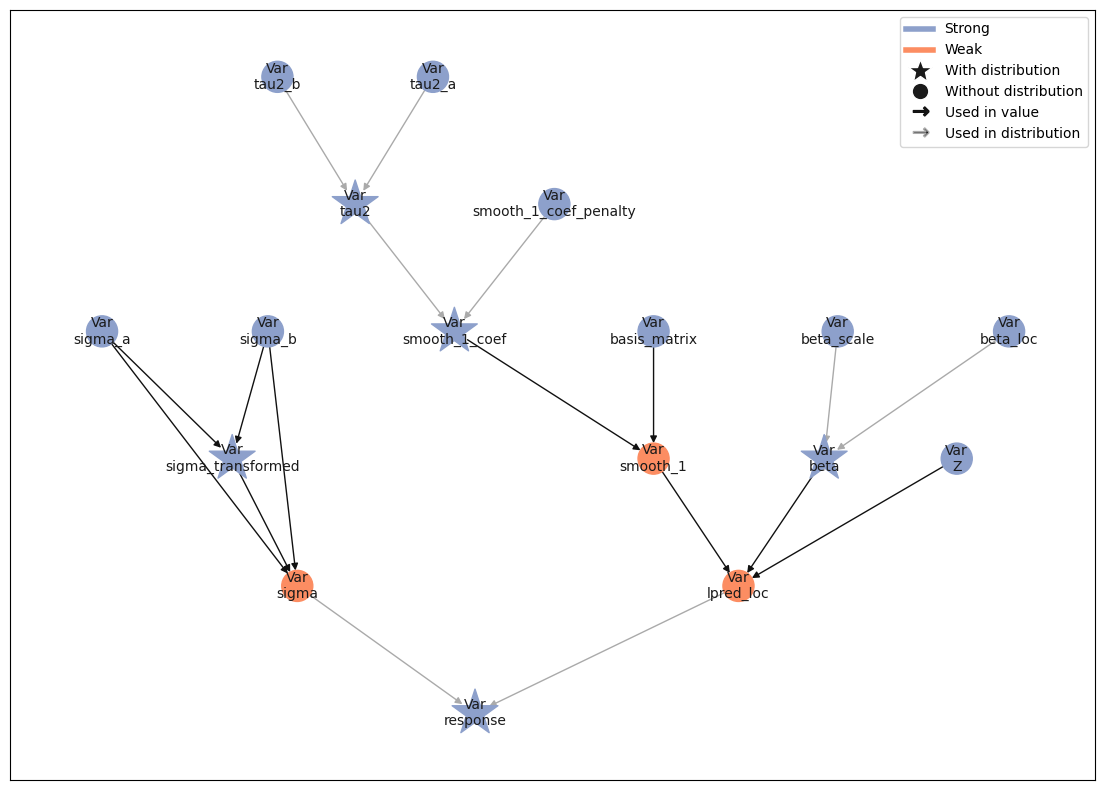

In [22]:
lsl.plot_vars(model)

In [23]:
def tau2_gibbs_kernel(p_spline: PSpline) -> gs.GibbsKernel:
    """Builds a Gibbs kernel for a smoothing parameter with an inverse gamma prior."""
    position_key = p_spline["tau2"].name

    def transition(prng_key, model_state):
        a_prior = p_spline.value_from(model_state, "a")
        b_prior = p_spline.value_from(model_state, "b")

        rank = p_spline.value_from(model_state, "rank")
        K = p_spline.value_from(model_state, "penalty")

        beta = p_spline.value_from(model_state, "coef")

        a_gibbs = jnp.squeeze(a_prior + 0.5 * rank)
        b_gibbs = jnp.squeeze(b_prior + 0.5 * (beta @ K @ beta))

        draw = b_gibbs / jax.random.gamma(prng_key, a_gibbs)

        return {position_key: draw}

    return gs.GibbsKernel([position_key], transition)

In [24]:
builder = gs.EngineBuilder(seed=1337, num_chains=4)

builder.set_model(lsl.GooseModel(model))
builder.set_initial_values(model.state)

builder.add_kernel(tau2_gibbs_kernel(smooth_group_1))
builder.add_kernel(gs.IWLSKernel(["smooth_1_coef"]))
builder.add_kernel(gs.IWLSKernel(["beta"]))
builder.add_kernel(gs.NUTSKernel(["sigma_transformed"]))

builder.set_duration(warmup_duration=1000, posterior_duration=1000)

builder.positions_included = ["sigma"]

engine = builder.build()

liesel.goose.builder - WARNING - No jitter functions provided. The initial values won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done


In [25]:
engine.sample_all_epochs()

liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 75 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 3, 3, 3, 4 / 75 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 2, 1, 1, 1 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 50 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 2, 2, 2, 1 / 50 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 100 transitions, 25 jitted together
liesel.goose.engine - WARNING - Errors per chain for kernel_03: 3, 1, 1, 1 / 100 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 200 

In [26]:
results = engine.get_results()
gs.Summary(results)

Parameter summary:

                            kernel      mean        sd    q_0.05     q_0.5  \
parameter         index                                                      
beta              (0,)   kernel_02  3.042938  0.046123  2.966970  3.043725   
sigma             ()             -  1.500185  0.034901  1.444190  1.498909   
sigma_transformed ()     kernel_03  0.405318  0.023243  0.367548  0.404738   
smooth_1_coef     (0,)   kernel_01  1.796289  0.190949  1.478946  1.800313   
                  (1,)   kernel_01  1.782781  0.210180  1.435113  1.777259   
                  (2,)   kernel_01 -2.237251  0.328487 -2.775015 -2.235497   
                  (3,)   kernel_01 -2.322870  0.372097 -2.924318 -2.327314   
                  (4,)   kernel_01  1.170263  0.416057  0.483642  1.174221   
                  (5,)   kernel_01  2.301516  0.425954  1.596244  2.302374   
                  (6,)   kernel_01  0.270290  0.393555 -0.384980  0.268040   
                  (7,)   kernel_01 -2.711710  0.400934 -3.387029 -2.708469   
                  (8,)   kernel_01 -0.718253  0.417796 -1.415068 -0.712043   
                  (9,)   kernel_01  1.305000  0.372098  0.706672  1.298032   
                  (10,)  kernel_01  2.188916  0.382100  1.551863  2.198306   
                  (11,)  kernel_01 -0.083147  0.385980 -0.711028 -0.085811   
                  (12,)  kernel_01 -2.394630  0.380824 -3.013100 -2.408575   
                  (13,)  kernel_01 -0.824253  0.411932 -1.500245 -0.835842   
                  (14,)  kernel_01  1.425333  0.413320  0.708042  1.445563   
                  (15,)  kernel_01  2.365875  0.362548  1.777591  2.367320   
                  (16,)  kernel_01 -1.352986  0.226433 -1.736828 -1.350117   
                  (17,)  kernel_01 -1.734871  0.203072 -2.060502 -1.733030   
                  (18,)  kernel_01 -0.219414  0.197820 -0.545226 -0.218612   
tau2              ()     kernel_00  9.693753  3.714947  5.200878  8.970852   

                            q_0.95  sample_size     ess_bulk     ess_tail  \
parameter         index                                                     
beta              (0,)    3.118197         4000  1578.525520  2307.949839   
sigma             ()      1.559358         4000  1596.736013  2035.758061   
sigma_transformed ()      0.444274         4000  1596.735814  2035.758061   
smooth_1_coef     (0,)    2.106353         4000   351.763965   808.183456   
                  (1,)    2.126258         4000   265.383504   682.615605   
                  (2,)   -1.700339         4000   355.664957   825.299280   
                  (3,)   -1.710365         4000   330.715126   633.855307   
                  (4,)    1.864176         4000   338.951899   633.376516   
                  (5,)    2.989052         4000   308.067654   662.400460   
                  (6,)    0.914050         4000   274.614062   571.407745   
                  (7,)   -2.051442         4000   241.676045   631.757619   
                  (8,)   -0.009842         4000   338.679580   677.866082   
                  (9,)    1.913144         4000   391.787042   547.452032   
                  (10,)   2.816838         4000   348.231328   775.081659   
                  (11,)   0.555662         4000   297.091718   611.136681   
                  (12,)  -1.757746         4000   375.684599   781.359271   
                  (13,)  -0.118718         4000   371.162762   701.825120   
                  (14,)   2.080814         4000   341.371202   754.833248   
                  (15,)   2.954713         4000   271.576577   494.696243   
                  (16,)  -0.991314         4000   291.001682   728.839641   
                  (17,)  -1.395965         4000   291.443480   701.280168   
                  (18,)   0.103765         4000   355.202072   743.333906   
tau2              ()     16.739142         4000  1274.138423  2908.698902   

                             rhat  
parameter         index            
beta              (0,)   1.0017

In [27]:
p = gs.Summary(results).quantities

In [36]:
post_samples = results.get_posterior_samples()

{'beta': array([3.0429375], dtype=float32),
 'sigma': array(1.5001848, dtype=float32),
 'sigma_transformed': array(0.40531802, dtype=float32),
 'smooth_1_coef': array([ 1.7962893 ,  1.7827814 , -2.2372513 , -2.32287   ,  1.1702632 ,
         2.3015163 ,  0.27029034, -2.7117105 , -0.7182533 ,  1.3050004 ,
         2.1889164 , -0.08314718, -2.3946302 , -0.8242532 ,  1.4253328 ,
         2.3658748 , -1.3529861 , -1.7348707 , -0.2194138 ], dtype=float32),
 'tau2': array(9.693753, dtype=float32)}

## Comparison 

In [28]:
b_fixed = p["mean"]["beta"]
b_smooth = p["mean"]["smooth_1_coef"]
b = jnp.concatenate((b_fixed, b_smooth))
y_opt = X.design_matrix @ b

In [30]:
pred_data_lsl = pd.DataFrame({"x": x, "y":y_opt})
sort_pred_data_lsl = pred_data_lsl.sort_values("x")

In [35]:
jnp.mean(sort_pred_data_tiger["y"].to_numpy()- sort_pred_data_lsl["y"].to_numpy())

Array(-0.00725875, dtype=float32)

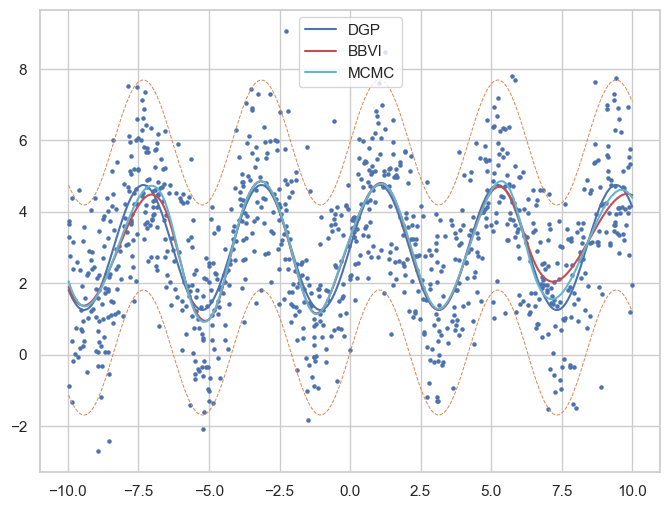

In [32]:
# plot the data
sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

plt.scatter(x=sort_df["x"], y=sort_df["y"], s=5)
plt.plot(sort_df["x"], sort_df["loc"], label="DGP")
plt.plot(sort_df["x"], sort_df["loc"] + 1.96*sort_df["scale"], linewidth=0.7, color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_df["x"], sort_df["loc"] - 1.96*sort_df["scale"], linewidth=0.7, color=sns.color_palette()[1], linestyle='dashed')
plt.plot(sort_pred_data_tiger["x"], sort_pred_data_tiger["y"], color = "r", label = "BBVI")
plt.plot(sort_pred_data_lsl["x"], sort_pred_data_lsl["y"], color = "c", label = "MCMC")
plt.legend()
plt.show()

sns.reset_orig()

## Compare the posteriors 

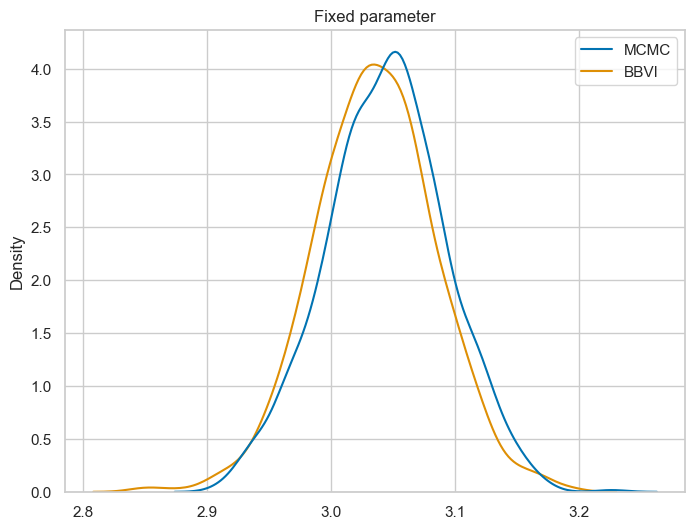

In [91]:
# Fixed parameter 
# BBVI (tiger)
loc, cov = q.trans_var_params["beta_fixed"]["loc"], q.trans_var_params["beta_fixed"]["cov"]
samples_beta_fixed_tiger = tfjd.Normal(loc=loc, scale=jnp.squeeze(jnp.sqrt(cov))).sample(1000, seed=jax.random.PRNGKey(0))

# MCMC (liesel)
samples_beta_liesel = post_samples["beta"][0,:]

plot_data = pd.DataFrame({"MCMC": jnp.squeeze(samples_beta_liesel), "BBVI": jnp.squeeze(samples_beta_fixed_tiger)})

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

sns.kdeplot(plot_data, palette="colorblind")
plt.title("Fixed parameter")
plt.show()

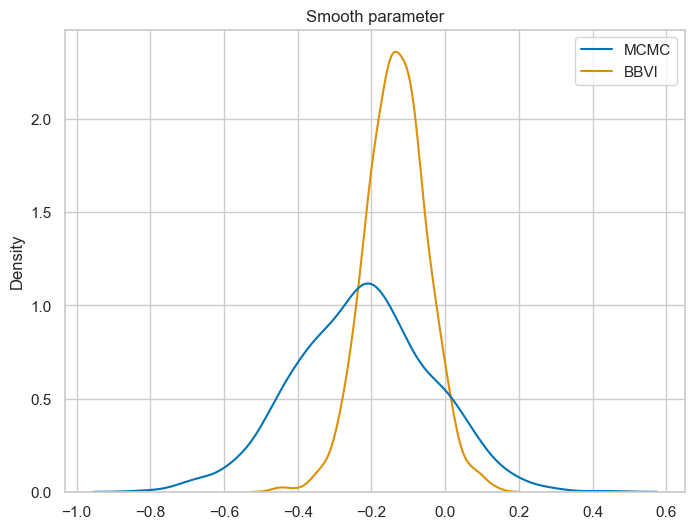

In [89]:
# Smooth parameter 
# choose parameter 
n = 19

# BBVI (tiger)
loc, cov = q.trans_var_params["beta_smooth"]["loc"], q.trans_var_params["beta_smooth"]["cov"]
samples_beta_fixed_tiger = tfjd.Normal(loc=loc[n], scale=jnp.squeeze(jnp.sqrt(cov[n,n]))).sample(1000, seed=jax.random.PRNGKey(0))

# MCMC (liesel)
samples_beta_liesel = post_samples["smooth_1_coef"][0,:, n]

plot_data = pd.DataFrame({"MCMC": jnp.squeeze(samples_beta_liesel), "BBVI": jnp.squeeze(samples_beta_fixed_tiger)})

sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

sns.kdeplot(plot_data, palette="colorblind")
plt.title("Smooth parameter")
plt.show()

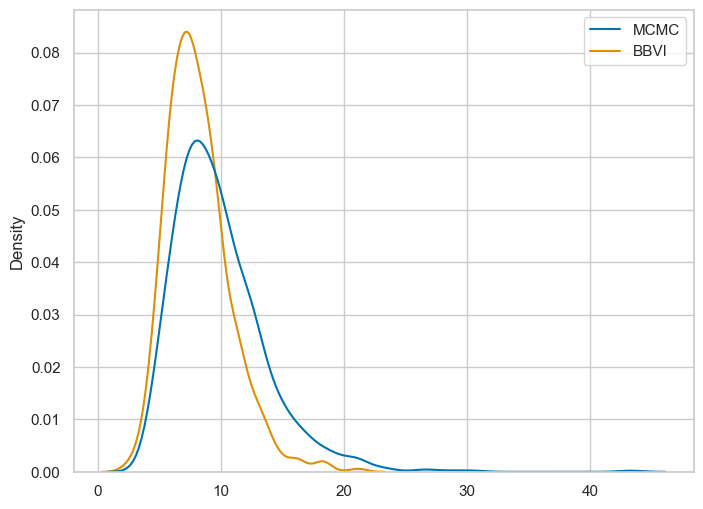

In [74]:
# Inverse smoothing parameter
# BBVI (tiger)
loc, cov = q.trans_var_params["tau"]["loc"], q.trans_var_params["tau"]["cov"]
samples_tau_tiger = tfjd.Normal(loc=loc, scale=jnp.squeeze(jnp.sqrt(cov))).sample(1000, seed=jax.random.PRNGKey(0))
samples_tau2_tiger = jnp.exp(samples_tau_tiger)**2
# MCMC (liesel)
samples_tau2_liesel = post_samples["tau2"][0,:]

plot_data = pd.DataFrame({"MCMC": jnp.squeeze(samples_tau2_liesel), "BBVI": jnp.squeeze(samples_tau2_tiger)})


sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

sns.kdeplot(plot_data, palette="colorblind")
plt.title("Inverse smoothing parameter")
plt.show()

In [93]:
loc

Array([0.4134498], dtype=float32)

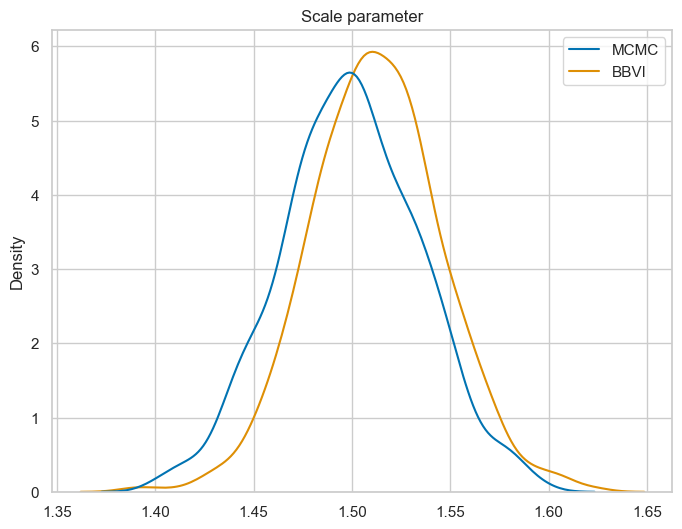

In [94]:
# Scale parameter
# BBVI (tiger)
loc, cov = q.trans_var_params["sigma"]["loc"], q.trans_var_params["sigma"]["cov"]
samples_sigma_tiger = tfjd.Normal(loc=loc, scale=jnp.squeeze(jnp.sqrt(cov))).sample(1000, seed=jax.random.PRNGKey(0))
samples_sigma_tiger = jnp.exp(samples_sigma_tiger)
# MCMC (liesel)
samples_sigma_liesel = post_samples["sigma"][0,:]

plot_data = pd.DataFrame({"MCMC": jnp.squeeze(samples_sigma_liesel), "BBVI": jnp.squeeze(samples_sigma_tiger)})


sns.set_theme(style="whitegrid")
fig = plt.figure(figsize=(8,6))

sns.kdeplot(plot_data, palette="colorblind")
plt.title("Scale parameter")
plt.show()